In [1]:
import sys
import numpy as np
import pandas as pd
sys.path.insert(0, "../utils/")
from data_loader import load_data
from scipy.stats import ttest_ind 
from scipy.stats import f_oneway
import pathlib

In [2]:
latent_dir = pathlib.Path("../2.train-VAE/results/latent_df.parquet").resolve()
latent_df = pd.read_parquet(latent_dir)
metadata_dir = pathlib.Path(".././0.data-download/data/metadata_df.parquet").resolve()
metadata_df = pd.read_parquet(metadata_dir)
data_dir = pathlib.Path("../0.data-download/data/").resolve()
model_df, dependency_df = load_data(data_dir, adult_or_pediatric="all")
gsea_results_dir = pathlib.Path("../3.analysis/results/combined_gsea_results.parquet.gz").resolve()
gsea_results_df = pd.read_parquet(gsea_results_dir)
all_GSEA_results_dir = pathlib.Path("../3.analysis/results/all_gsea_results.parquet.gz").resolve()
all_GSEA_results_df = pd.read_parquet(all_GSEA_results_dir)
significant_gsea_dir = pathlib.Path("../3.analysis/results/significant_gsea_results.parquet.gz")
significant_gsea_df = pd.read_parquet(significant_gsea_dir)

In [3]:
# Creating categorized lists of sample IDs used in BVAE training
# note that 10 of the 912 used samples have Unknown Sex

ped_ids = metadata_df.query("AgeCategory == 'Pediatric'").ModelID.tolist()
adult_ids = metadata_df.query("AgeCategory == 'Adult'").ModelID.tolist()
male_ids = metadata_df.query("Sex == 'Male'").ModelID.tolist()
female_ids = metadata_df.query("Sex == 'Female'").ModelID.tolist()
ped_male_ids = metadata_df.query("AgeCategory == 'Pediatric'").query("Sex == 'Male'").ModelID.tolist()
adult_male_ids = metadata_df.query("AgeCategory == 'Adult'").query("Sex == 'Male'").ModelID.tolist()
ped_female_ids = metadata_df.query("AgeCategory == 'Pediatric'").query("Sex == 'Female'").ModelID.tolist()
adult_female_ids = metadata_df.query("AgeCategory == 'Adult'").query("Sex == 'Female'").ModelID.tolist()

In [4]:
# Generating latent dataframes for each category and dropping the id column to prep for t tests
def generate_latent_df(latent_df, category_ids):
    """
    Generate a latent DataFrame filtered by category IDs and drop the 'ModelID' column.

    Parameters:
    latent_df (pd.DataFrame): The original DataFrame containing latent variables.
    category_ids (list): The list of ModelIDs to filter the DataFrame by.

    Returns:
    pd.DataFrame: The filtered DataFrame with the 'ModelID' column dropped.
    """
    filtered_df = latent_df[latent_df['ModelID'].isin(category_ids)].copy()
    filtered_df_float = filtered_df.drop(columns=["ModelID"])
    filtered_df_float.reset_index(drop=True, inplace=True)
    return filtered_df, filtered_df_float


# Usage for each category
adult_latent_df, adult_latent_df_float = generate_latent_df(latent_df, adult_ids)
ped_latent_df, ped_latent_df_float = generate_latent_df(latent_df, ped_ids)
male_latent_df, male_latent_df_float = generate_latent_df(latent_df, male_ids)
female_latent_df, female_latent_df_float = generate_latent_df(latent_df, female_ids)
ped_male_latent_df, ped_male_latent_df_float = generate_latent_df(latent_df, ped_male_ids)
adult_male_latent_df, adult_male_latent_df_float = generate_latent_df(latent_df, adult_male_ids)
ped_female_latent_df, ped_female_latent_df_float = generate_latent_df(latent_df, ped_female_ids)
adult_female_latent_df, adult_female_latent_df_float = generate_latent_df(latent_df, adult_female_ids)

In [5]:
# t tests comparing adult vs ped for each latent dimension

t_test_adult_vs_ped = ttest_ind(adult_latent_df_float, ped_latent_df_float)
t_test_adult_vs_ped = pd.DataFrame(t_test_adult_vs_ped).T
t_test_adult_vs_ped.columns = ["t_stat", "p_value"]
t_test_adult_vs_ped['comparison'] = 'Adult vs Pediatric'
t_test_adult_vs_ped['latent_feature'] = t_test_adult_vs_ped.index + 1
# Remove rows with NaN values
t_test_adult_vs_ped = t_test_adult_vs_ped.dropna()
print(t_test_adult_vs_ped.shape)

t_test_adult_vs_ped.head(50)

(21, 4)


,t_stat,p_value,comparison,latent_feature
2,-7.748536,2.368315e-14,Adult vs Pediatric,3
3,-5.506403,4.706613e-08,Adult vs Pediatric,4
4,2.141809,3.246097e-02,Adult vs Pediatric,5
8,-3.374685,7.687156e-04,Adult vs Pediatric,9
9,0.253860,7.996586e-01,Adult vs Pediatric,10
10,-3.193699,1.450557e-03,Adult vs Pediatric,11
12,-4.190161,3.045700e-05,Adult vs Pediatric,13
14,-3.548046,4.069664e-04,Adult vs Pediatric,15
15,-3.580209,3.605916e-04,Adult vs Pediatric,16
17,-5.093403,4.236162e-07,Adult vs Pediatric,18


In [6]:
# t tests comparing male vs female for each latent dimension

t_test_male_vs_female = ttest_ind(male_latent_df_float, female_latent_df_float)
t_test_male_vs_female = pd.DataFrame(t_test_male_vs_female).T
t_test_male_vs_female.columns = ["t_stat", "p_value"]
t_test_male_vs_female['comparison'] = 'Male vs Female'
t_test_male_vs_female['latent_feature'] = t_test_male_vs_female.index + 1
# Remove rows with NaN values
t_test_male_vs_female = t_test_male_vs_female.dropna()
print(t_test_male_vs_female.shape)

t_test_male_vs_female.head()

(21, 4)


,t_stat,p_value,comparison,latent_feature
2,2.181828,0.029368,Male vs Female,3
3,2.322543,0.020415,Male vs Female,4
4,0.542237,0.587783,Male vs Female,5
8,1.946047,0.051945,Male vs Female,9
9,0.840074,0.401079,Male vs Female,10


In [7]:
# t tests comparing adult male vs ped male for each latent dimension

t_test_adult_male_vs_ped_male = ttest_ind(ped_male_latent_df_float, adult_male_latent_df_float)
t_test_adult_male_vs_ped_male = pd.DataFrame(t_test_adult_male_vs_ped_male).T
t_test_adult_male_vs_ped_male.columns = ["t_stat", "p_value"]
t_test_adult_male_vs_ped_male['comparison'] = 'Adult Male vs Pediatric Male'
t_test_adult_male_vs_ped_male['latent_feature'] = t_test_adult_male_vs_ped_male.index + 1
# Remove rows with NaN values
t_test_adult_male_vs_ped_male = t_test_adult_male_vs_ped_male.dropna()
print(t_test_adult_male_vs_ped_male.shape)

t_test_adult_male_vs_ped_male.head()

(20, 4)


,t_stat,p_value,comparison,latent_feature
2,4.884556,0.000001,Adult Male vs Pediatric Male,3
3,3.166591,0.001630,Adult Male vs Pediatric Male,4
4,-1.935782,0.053418,Adult Male vs Pediatric Male,5
8,1.737692,0.082837,Adult Male vs Pediatric Male,9
9,-0.073237,0.941645,Adult Male vs Pediatric Male,10


In [8]:
# t tests comparing adult female vs ped female for each latent dimension

t_test_adult_female_vs_ped_female = ttest_ind(ped_female_latent_df_float, adult_female_latent_df_float)
t_test_adult_female_vs_ped_female = pd.DataFrame(t_test_adult_female_vs_ped_female).T
t_test_adult_female_vs_ped_female.columns = ["t_stat", "p_value"]
t_test_adult_female_vs_ped_female['comparison'] = 'Adult Female vs Pediatric Female'
t_test_adult_female_vs_ped_female['latent_feature'] = t_test_adult_female_vs_ped_female.index + 1
# Remove rows with NaN values
t_test_adult_female_vs_ped_female = t_test_adult_female_vs_ped_female.dropna()
print(t_test_adult_female_vs_ped_female.shape)

t_test_adult_female_vs_ped_female.head()

(20, 4)


,t_stat,p_value,comparison,latent_feature
2,5.982100,4.838135e-09,Adult Female vs Pediatric Female,3
3,4.661514,4.264293e-06,Adult Female vs Pediatric Female,4
4,-0.768413,4.426889e-01,Adult Female vs Pediatric Female,5
8,3.159974,1.696012e-03,Adult Female vs Pediatric Female,9
9,-0.295629,7.676649e-01,Adult Female vs Pediatric Female,10


In [9]:
# t tests comparing ped male vs ped female for each latent dimension

t_test_ped_male_vs_ped_female = ttest_ind(ped_female_latent_df_float, ped_male_latent_df_float)
t_test_ped_male_vs_ped_female = pd.DataFrame(t_test_ped_male_vs_ped_female).T
t_test_ped_male_vs_ped_female.columns = ["t_stat", "p_value"]
t_test_ped_male_vs_ped_female['comparison'] = 'Pediatric Male vs Pediatric Female'
t_test_ped_male_vs_ped_female['latent_feature'] = t_test_ped_male_vs_ped_female.index + 1
# Remove rows with NaN values
t_test_ped_male_vs_ped_female = t_test_ped_male_vs_ped_female.dropna()
print(t_test_ped_male_vs_ped_female.shape)

t_test_ped_male_vs_ped_female.head()

(19, 4)


,t_stat,p_value,comparison,latent_feature
2,0.354137,0.723797,Pediatric Male vs Pediatric Female,3
3,0.462271,0.644643,Pediatric Male vs Pediatric Female,4
4,0.537998,0.591478,Pediatric Male vs Pediatric Female,5
8,0.330526,0.741522,Pediatric Male vs Pediatric Female,9
9,-0.560741,0.575918,Pediatric Male vs Pediatric Female,10


In [10]:
# t tests comparing adult male vs adult female for each latent dimension

t_test_adult_male_vs_adult_female = ttest_ind(adult_female_latent_df_float, adult_male_latent_df_float)
t_test_adult_male_vs_adult_female = pd.DataFrame(t_test_adult_male_vs_adult_female).T
t_test_adult_male_vs_adult_female.columns = ["t_stat", "p_value"]
t_test_adult_male_vs_adult_female['comparison'] = 'Adult Male vs Adult Female'
t_test_adult_male_vs_adult_female['latent_feature'] = t_test_adult_male_vs_adult_female.index + 1
# Remove rows with NaN values
t_test_adult_male_vs_adult_female = t_test_adult_male_vs_adult_female.dropna()
print(t_test_adult_male_vs_adult_female.shape)

t_test_adult_male_vs_adult_female.head()

(21, 4)


,t_stat,p_value,comparison,latent_feature
2,-2.458102,0.014175,Adult Male vs Adult Female,3
3,-2.655202,0.008082,Adult Male vs Adult Female,4
4,-0.767381,0.443079,Adult Male vs Adult Female,5
8,-2.237073,0.025553,Adult Male vs Adult Female,9
9,-0.698069,0.485334,Adult Male vs Adult Female,10


In [11]:
# Combining and saving t test results
t_test_results_df = pd.concat([
    t_test_adult_vs_ped, 
    t_test_male_vs_female, 
    t_test_adult_male_vs_ped_male, 
    t_test_adult_female_vs_ped_female, 
    t_test_ped_male_vs_ped_female, 
    t_test_adult_male_vs_adult_female
]).reset_index(drop=True)
t_test_results_dir = pathlib.Path("./results/t_test_results.tsv")
t_test_results_df.to_parquet(t_test_results_dir)

# sort to show most significant p-values
t_test_results_df.sort_values(by='p_value', ascending = True)

,t_stat,p_value,comparison,latent_feature
11,-8.654948,2.065703e-17,Adult vs Pediatric,20
17,-7.998222,3.632025e-15,Adult vs Pediatric,29
0,-7.748536,2.368315e-14,Adult vs Pediatric,3
73,6.694249,7.228703e-11,Adult Female vs Pediatric Female,20
20,-6.266786,5.567835e-10,Adult vs Pediatric,36
...,...,...,...,...
97,0.147721,8.827863e-01,Pediatric Male vs Pediatric Female,29
91,0.125205,9.005506e-01,Pediatric Male vs Pediatric Female,18
95,0.080225,9.361791e-01,Pediatric Male vs Pediatric Female,25
46,-0.073237,9.416451e-01,Adult Male vs Pediatric Male,10


In [12]:
# ANOVA Testing
f_statistic, p_value = f_oneway(adult_male_latent_df_float, ped_male_latent_df_float, adult_female_latent_df_float, ped_female_latent_df_float)
anova_df = pd.DataFrame({'f_stat': f_statistic.tolist(), 'p_value': p_value.tolist()})
anova_df['latent_feature'] = anova_df.index + 1
# Remove rows with NaN values
anova_df = anova_df.dropna()
anova_df

/home/juliacurd/anaconda3/envs/gene_dependency_representations/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:605: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


,f_stat,p_value,latent_feature
2,21.290885,2.380494e-13,3
3,12.278153,6.950643e-08,4
4,1.577736,1.931691e-01,5
8,5.407126,1.085737e-03,9
9,0.266479,8.495816e-01,10
10,4.042412,7.192526e-03,11
12,6.651705,1.905548e-04,13
14,5.257589,1.337131e-03,15
15,4.782322,2.588042e-03,16
17,9.439320,3.782029e-06,18


In [13]:
#Lung cancer in adults vs neuroblastoma in peds comparison

# Extract Neuroblastoma model IDs from the model dataframe
NB_ids = model_df.query("OncotreePrimaryDisease == 'Neuroblastoma'").ModelID.tolist()

# Create a copy of the pediatric latent space dataframe
ped_NB_latent_df = ped_latent_df.copy()

# Filter the pediatric latent dataframe to include only Neuroblastoma models
for index, row in ped_NB_latent_df.iterrows():
    if row['ModelID'] not in NB_ids:
        ped_NB_latent_df.drop(index, inplace=True)

# Drop the 'ModelID' column from the filtered pediatric latent dataframe
# and reset the index
ped_NB_latent_float_df = ped_NB_latent_df.drop(columns=["ModelID"])
ped_NB_latent_float_df.reset_index(drop=True, inplace=True)

# Extract Non-Small Cell Lung Cancer (NSCLC) model IDs from the model dataframe
LC_ids = model_df.query("OncotreePrimaryDisease == 'Non-Small Cell Lung Cancer'").ModelID.tolist()

# Create a copy of the adult latent space dataframe
adult_LC_latent_df = adult_latent_df.copy()

# Filter the adult latent dataframe to include only NSCLC models
for index, row in adult_LC_latent_df.iterrows():
    if row['ModelID'] not in LC_ids:
        adult_LC_latent_df.drop(index, inplace=True)

# Drop the 'ModelID' column from the filtered adult latent dataframe
# and reset the index
adult_LC_latent_float_df = adult_LC_latent_df.drop(columns=["ModelID"])
adult_LC_latent_float_df.reset_index(drop=True, inplace=True)

In [14]:
# t tests comparing Lung Cancer in adult vs Neuroblastoma in ped for each latent dimension

t_test_diff_adult_vs_ped = ttest_ind(adult_LC_latent_float_df, ped_NB_latent_float_df)
t_test_diff_adult_vs_ped = pd.DataFrame(t_test_diff_adult_vs_ped).T
t_test_diff_adult_vs_ped.columns = ["t_stat", "p_value"]
t_test_diff_adult_vs_ped['comparison'] = 'Adult vs Pediatric'
t_test_diff_adult_vs_ped['latent_feature'] = t_test_diff_adult_vs_ped.index + 1
# Remove rows with NaN values
t_test_diff_adult_vs_ped = t_test_diff_adult_vs_ped.dropna()
print(t_test_diff_adult_vs_ped.shape)

t_test_diff_adult_vs_ped.sort_values(by = 'p_value', ascending= True)

(19, 4)


,t_stat,p_value,comparison,latent_feature
28,-7.389990,2.729935e-11,Adult vs Pediatric,29
19,-7.061477,1.425687e-10,Adult vs Pediatric,20
2,-6.352402,4.588353e-09,Adult vs Pediatric,3
35,-4.213745,5.075825e-05,Adult vs Pediatric,36
18,-3.648284,4.009733e-04,Adult vs Pediatric,19
3,-3.416716,8.816979e-04,Adult vs Pediatric,4
17,-3.202016,1.772762e-03,Adult vs Pediatric,18
31,-2.845978,5.259031e-03,Adult vs Pediatric,32
26,-2.751218,6.917365e-03,Adult vs Pediatric,27
29,-2.727113,7.409112e-03,Adult vs Pediatric,30


In [15]:
# Obtaining shared cancer types in ped and adult
adult_types = model_df.query("AgeCategory == 'Adult'").OncotreePrimaryDisease.tolist()
adult_types = [x for x in adult_types if adult_types.count(x) >= 5]
adult_types = list(set(adult_types))

ped_types = model_df.query("AgeCategory == 'Pediatric'").OncotreePrimaryDisease.tolist()
ped_types = [x for x in ped_types if ped_types.count(x) >= 5]
ped_types = list(set(ped_types))

shared_types = set(adult_types) & set(ped_types)
shared_types

{'Acute Myeloid Leukemia', 'Ewing Sarcoma', 'Mature B-Cell Neoplasms'}

In [16]:
# Comparing the shared cancer types
# Initialize a list to store the t-test results for each shared cancer type
comp_dfs = []

# Iterate over each cancer type shared between adult and pediatric datasets
for cancer_type in shared_types:
    # Extract the model IDs for the current cancer type from the model dataframe
    type_ids = model_df.query("OncotreePrimaryDisease == " + "'" + cancer_type + "'").ModelID.tolist()

    # Filter the pediatric latent dataframe to include only models of the current cancer type
    ped_type_latent_df = ped_latent_df.copy()
    ped_type_latent_df = ped_latent_df[ped_latent_df['ModelID'].isin(type_ids)].copy()

    # Drop the 'ModelID' column and reset the index in the pediatric latent dataframe
    ped_type_latent_float_df = ped_type_latent_df.drop(columns=["ModelID"])
    ped_type_latent_float_df.reset_index(drop=True, inplace=True)

    # Filter the adult latent dataframe to include only models of the current cancer type
    adult_type_latent_df = adult_latent_df.copy()
    adult_type_latent_df = adult_latent_df[adult_latent_df['ModelID'].isin(type_ids)].copy()

    # Drop the 'ModelID' column and reset the index in the adult latent dataframe
    adult_type_latent_float_df = adult_type_latent_df.drop(columns=["ModelID"])
    adult_type_latent_float_df.reset_index(drop=True, inplace=True)

    # Perform a t-test comparing the latent features between adult and pediatric datasets
    t_test_type_adult_vs_ped = ttest_ind(adult_type_latent_float_df, ped_type_latent_float_df)

    # Convert the t-test results to a DataFrame and add additional information
    t_test_type_adult_vs_ped = pd.DataFrame(t_test_type_adult_vs_ped).T
    t_test_type_adult_vs_ped.columns = ["t_stat", "p_value"]
    t_test_type_adult_vs_ped['comparison'] = 'Adult vs Pediatric'
    t_test_type_adult_vs_ped['cancer_type'] = cancer_type
    t_test_type_adult_vs_ped['latent_feature'] = t_test_type_adult_vs_ped.index + 1

    # Append the t-test results for the current cancer type to the list
    comp_dfs.append(t_test_type_adult_vs_ped)

# Concatenate all the t-test results into a single DataFrame
t_test_type_results_df = pd.concat(comp_dfs).reset_index(drop=True)

# Remove any rows with NaN values from the results
t_test_type_results_df = t_test_type_results_df.dropna()

# Sort the t-test results by the p-value in ascending order
t_test_type_results_df.sort_values(by='p_value', ascending=True)

,t_stat,p_value,comparison,cancer_type,latent_feature
65,1.934971,0.064864,Adult vs Pediatric,Acute Myeloid Leukemia,30
40,1.582648,0.126592,Adult vs Pediatric,Acute Myeloid Leukemia,5
76,1.447738,0.162456,Adult vs Pediatric,Ewing Sarcoma,5
92,1.398757,0.176482,Adult vs Pediatric,Ewing Sarcoma,21
100,1.321288,0.200622,Adult vs Pediatric,Ewing Sarcoma,29
67,1.226582,0.231878,Adult vs Pediatric,Acute Myeloid Leukemia,32
54,1.224844,0.232520,Adult vs Pediatric,Acute Myeloid Leukemia,19
46,1.044534,0.306646,Adult vs Pediatric,Acute Myeloid Leukemia,11
60,1.036077,0.310493,Adult vs Pediatric,Acute Myeloid Leukemia,25
55,0.871355,0.392194,Adult vs Pediatric,Acute Myeloid Leukemia,20


In [17]:
# Prepare a DataFrame to store ANOVA results for multiple pathways
anova_results = []

# Add "z_" prefix to the latent dimensions in the t-test DataFrame
t_test_adult_vs_ped['z_dim'] = 'z_' + t_test_adult_vs_ped['latent_feature'].astype(str)
t_test_adult_vs_ped['group'] = t_test_adult_vs_ped['t_stat'].apply(lambda x: 'Adult' if x > 0 else 'Pediatric')

# Filter significant latent features
significant_latent_features = t_test_adult_vs_ped[t_test_adult_vs_ped['p_value'] < 0.05]

# Add the 'z_dim' column if not already added
significant_latent_features['z_dim'] = 'z_' + significant_latent_features['latent_feature'].astype(str)

# Loop through all unique pathways (Terms) in the GSEA DataFrame
for pathway in gsea_results_df['Term'].unique():
    # Filter for the pathway
    filtered_gsea_df = gsea_results_df[gsea_results_df['Term'] == pathway]
    
    # Further filter by significant latent features
    filtered_gsea_df = filtered_gsea_df[filtered_gsea_df['z_dim'].isin(significant_latent_features['z_dim'])]
    
    # Merge GSEA DataFrame with t-test DataFrame to get group information
    merged_df = pd.merge(filtered_gsea_df, significant_latent_features[['z_dim', 'group']], on='z_dim', how='inner')
    
    # Group by 'group' and collect ES values
    grouped_data = merged_df.groupby('group')['es'].apply(list)
    
    # Ensure we have data for both groups
    if len(grouped_data) == 2 and all(len(vals) > 1 for vals in grouped_data):
        # Perform ANOVA
        f_statistic, p_value = f_oneway(*grouped_data)

        # Determine which group has higher enrichment score
        adult_mean = np.mean(grouped_data['Adult'])
        pediatric_mean = np.mean(grouped_data['Pediatric'])
        higher_group = 'Adult' if adult_mean > pediatric_mean else 'Pediatric'

        # Store results
        anova_results.append({
            'Pathway': pathway,
            'F-statistic': f_statistic,
            'p-value': p_value,
            'Higher in': higher_group
        })

# Convert the results to a DataFrame
anova_results_df = pd.DataFrame(anova_results)

# Apply a significance threshold (e.g., p < 0.05)
significant_anova_results_df = anova_results_df[anova_results_df['p-value'] < 0.05]

anova_dir = pathlib.Path("./results/anova_results.csv")
significant_anova_results_df.to_csv(anova_dir)

# Display significant pathways
significant_anova_results_df.sort_values(by='F-statistic', key=abs, ascending = False).head(50)

/tmp/ipykernel_123166/728344406.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant_latent_features['z_dim'] = 'z_' + significant_latent_features['latent_feature'].astype(str)


,Pathway,F-statistic,p-value,Higher in
746,Netrin-1 Signaling R-HSA-373752,18.978815,0.000127,Pediatric
836,Response Of EIF2AK4 (GCN2) To Amino Acid Defic...,14.023585,0.000713,Pediatric
323,Metabolism Of Vitamins And Cofactors R-HSA-196854,11.052785,0.002229,Adult
654,Sealing Of Nuclear Envelope (NE) By ESCRT-III ...,9.770405,0.003758,Pediatric
5,Citric Acid (TCA) Cycle And Respiratory Electr...,9.618776,0.004003,Adult
1022,Metabolism R-HSA-1430728,9.391392,0.004402,Adult
427,CD209 (DC-SIGN) Signaling R-HSA-5621575,9.113350,0.004951,Pediatric
388,ERBB2 Regulates Cell Motility R-HSA-6785631,8.939169,0.005331,Pediatric
587,Transcriptional Regulation By TP53 R-HSA-3700989,8.839134,0.005564,Adult
10,Respiratory Electron Transport R-HSA-611105,8.790430,0.005681,Adult


/tmp/ipykernel_123166/1625018463.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant_anova_results_df.rename(columns={'Pathway': 'Term'}, inplace=True)


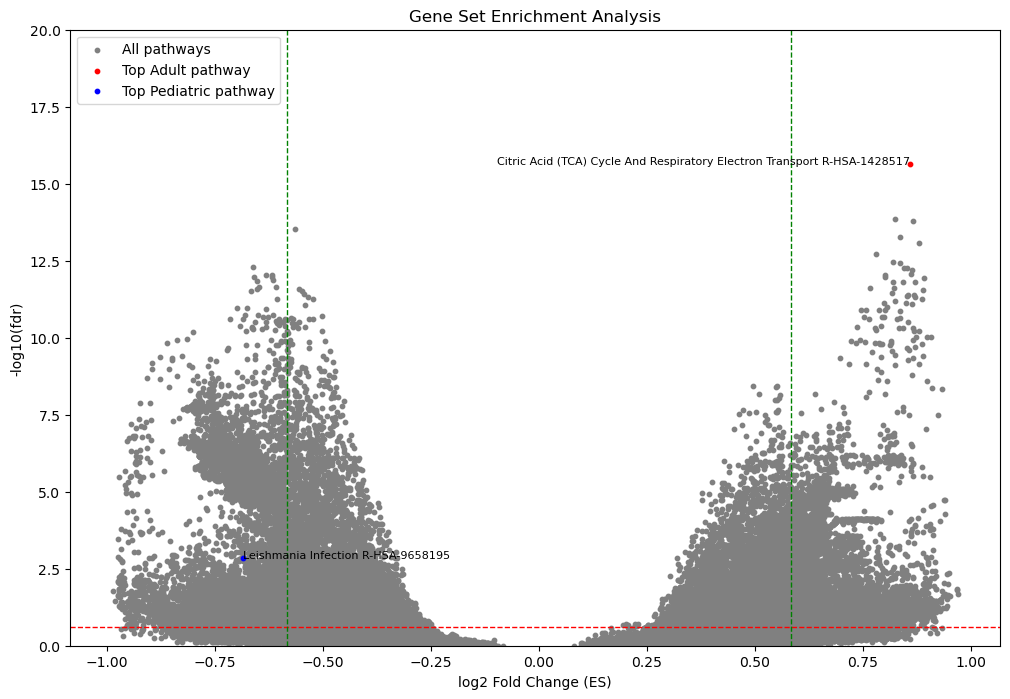

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Define cut-offs
lfc_cutoff = 0.584
fdr_cutoff = 0.25

# Merge GSEA results with ANOVA results based on the 'Pathway' column
significant_anova_results_df.rename(columns={'Pathway': 'Term'}, inplace=True)
merged_df = significant_gsea_df.merge(significant_anova_results_df[['Term', 'Higher in', 'F-statistic']], on='Term', how='left')

# Define masks for adult and pediatric pathways
adult_mask = merged_df['Higher in'] == 'Adult'
pediatric_mask = merged_df['Higher in'] == 'Pediatric'

# Sort by the absolute value of NES and select the top 5 adult and top 5 pediatric pathways
top_adult = merged_df[adult_mask].loc[merged_df[adult_mask]['nes'].abs().nlargest(1).index]
top_pediatric = merged_df[pediatric_mask].loc[merged_df[pediatric_mask]['nes'].abs().nlargest(1).index]

# Combine the top pathways
top_pathways_df = pd.concat([top_adult, top_pediatric])

# Create the plot
plt.figure(figsize=(12, 8))

# Plot all pathways in grey
plt.scatter(x=all_GSEA_results_df['es'], 
            y=all_GSEA_results_df['fdr'].apply(lambda x: -np.log10(x)), 
            s=10, color='grey', label='All pathways')

# Plot top adult pathways in red
plt.scatter(x=top_adult['es'], 
            y=top_adult['fdr'].apply(lambda x: -np.log10(x)), 
            s=10, color='red', label='Top Adult pathway')

# Plot top pediatric pathways in blue
plt.scatter(x=top_pediatric['es'], 
            y=top_pediatric['fdr'].apply(lambda x: -np.log10(x)), 
            s=10, color='blue', label='Top Pediatric pathway')

# Add LFC and FDR cut-off lines
plt.axhline(y=-np.log10(fdr_cutoff), color='r', linestyle='--', linewidth=1)
plt.axvline(x=lfc_cutoff, color='g', linestyle='--', linewidth=1)
plt.axvline(x=-lfc_cutoff, color='g', linestyle='--', linewidth=1)

# Add labels for the top pathways

for i in top_pathways_df.index:
    es_value = top_pathways_df.at[i, 'es']
    fdr_value = top_pathways_df.at[i, 'fdr']
    pathway_label = top_pathways_df.at[i, 'Term']
    
    # Add the label for each point
    plt.text((es_value), (-np.log10(fdr_value)), pathway_label, fontsize=8, ha='right' if es_value > 0 else 'left')


# Label axes and add title
plt.xlabel('log2 Fold Change (ES)')
plt.ylabel('-log10(fdr)')
plt.ylim(0, 20)
plt.title('Gene Set Enrichment Analysis')

# Add legend
plt.legend()

# Save the figure
gsea_save_path = pathlib.Path("../1.data-exploration/figures/gsea_top_labeled.png")
plt.savefig(gsea_save_path, bbox_inches="tight", dpi=600)

# Show the plot
plt.show()
